## Embeddings e Node2Vec: Modelos tradicionais de aprendizado de máquina são subótimos em grafos
 
![sd](https://pytorch-geometric.readthedocs.io/en/latest/_images/neighbor_loader.png "Title")

## Instalando dependências

In [1]:
!pip install torch_geometric
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.3.0+cpu.html
!pip install matplotlib networkx[default,extra]

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cpu.html


## Explorando o dataset 'Cora'
- Grafo de citações
- Vértices/Nós representam documentos
- Arestas representam citações entre documentos
- Cada vértice possui um conjunto de características (features): bag of words, indicando a ocorrência ou não de certas palavras de um dicionário nos documentos
- Cada vértice também possui uma classe de documento (7 classes)
- Referência: https://arxiv.org/pdf/1603.08861

In [34]:
from torch_geometric.datasets import Planetoid

# conjunto de dados já incluído no pyg, composto de um único grafo
#dataset = Planetoid(".", name='Cora', split="", force_reload=True)
dataset = Planetoid(".", name='Cora', split="public")
data = dataset[0]
print(f"\nGrafo Cora:\n{data}")
print(f"\nArestas:\n{data.edge_index}")
print(f"\nFeatures dos vértices (bag of words):\n{data.x}")
print(f"\nClasses dos vértices (categorias de documentos):\n{data.y}\n{data.y.unique()}")


Grafo Cora:
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

Arestas:
tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

Features dos vértices (bag of words):
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Classes dos vértices (categorias de documentos):
tensor([3, 4, 4,  ..., 3, 3, 3])
tensor([0, 1, 2, 3, 4, 5, 6])


### Entendendo as máscaras de treino, validação e teste
Observe que como ```split="public"```, as máscaras já estão fixadas da maneira que o dado foi utilizado no artigo publicado (reproducibilidade).

In [35]:
print(f"\nMáscara de treino:\n{data.train_mask}")
print(f"\nMáscara de validação:\n{data.val_mask}")
print(f"\nMáscara de teste:\n{data.test_mask}")


Máscara de treino:
tensor([ True,  True,  True,  ..., False, False, False])

Máscara de validação:
tensor([False, False, False,  ..., False, False, False])

Máscara de teste:
tensor([False, False, False,  ...,  True,  True,  True])


### Visualizando uma amostra do grafo

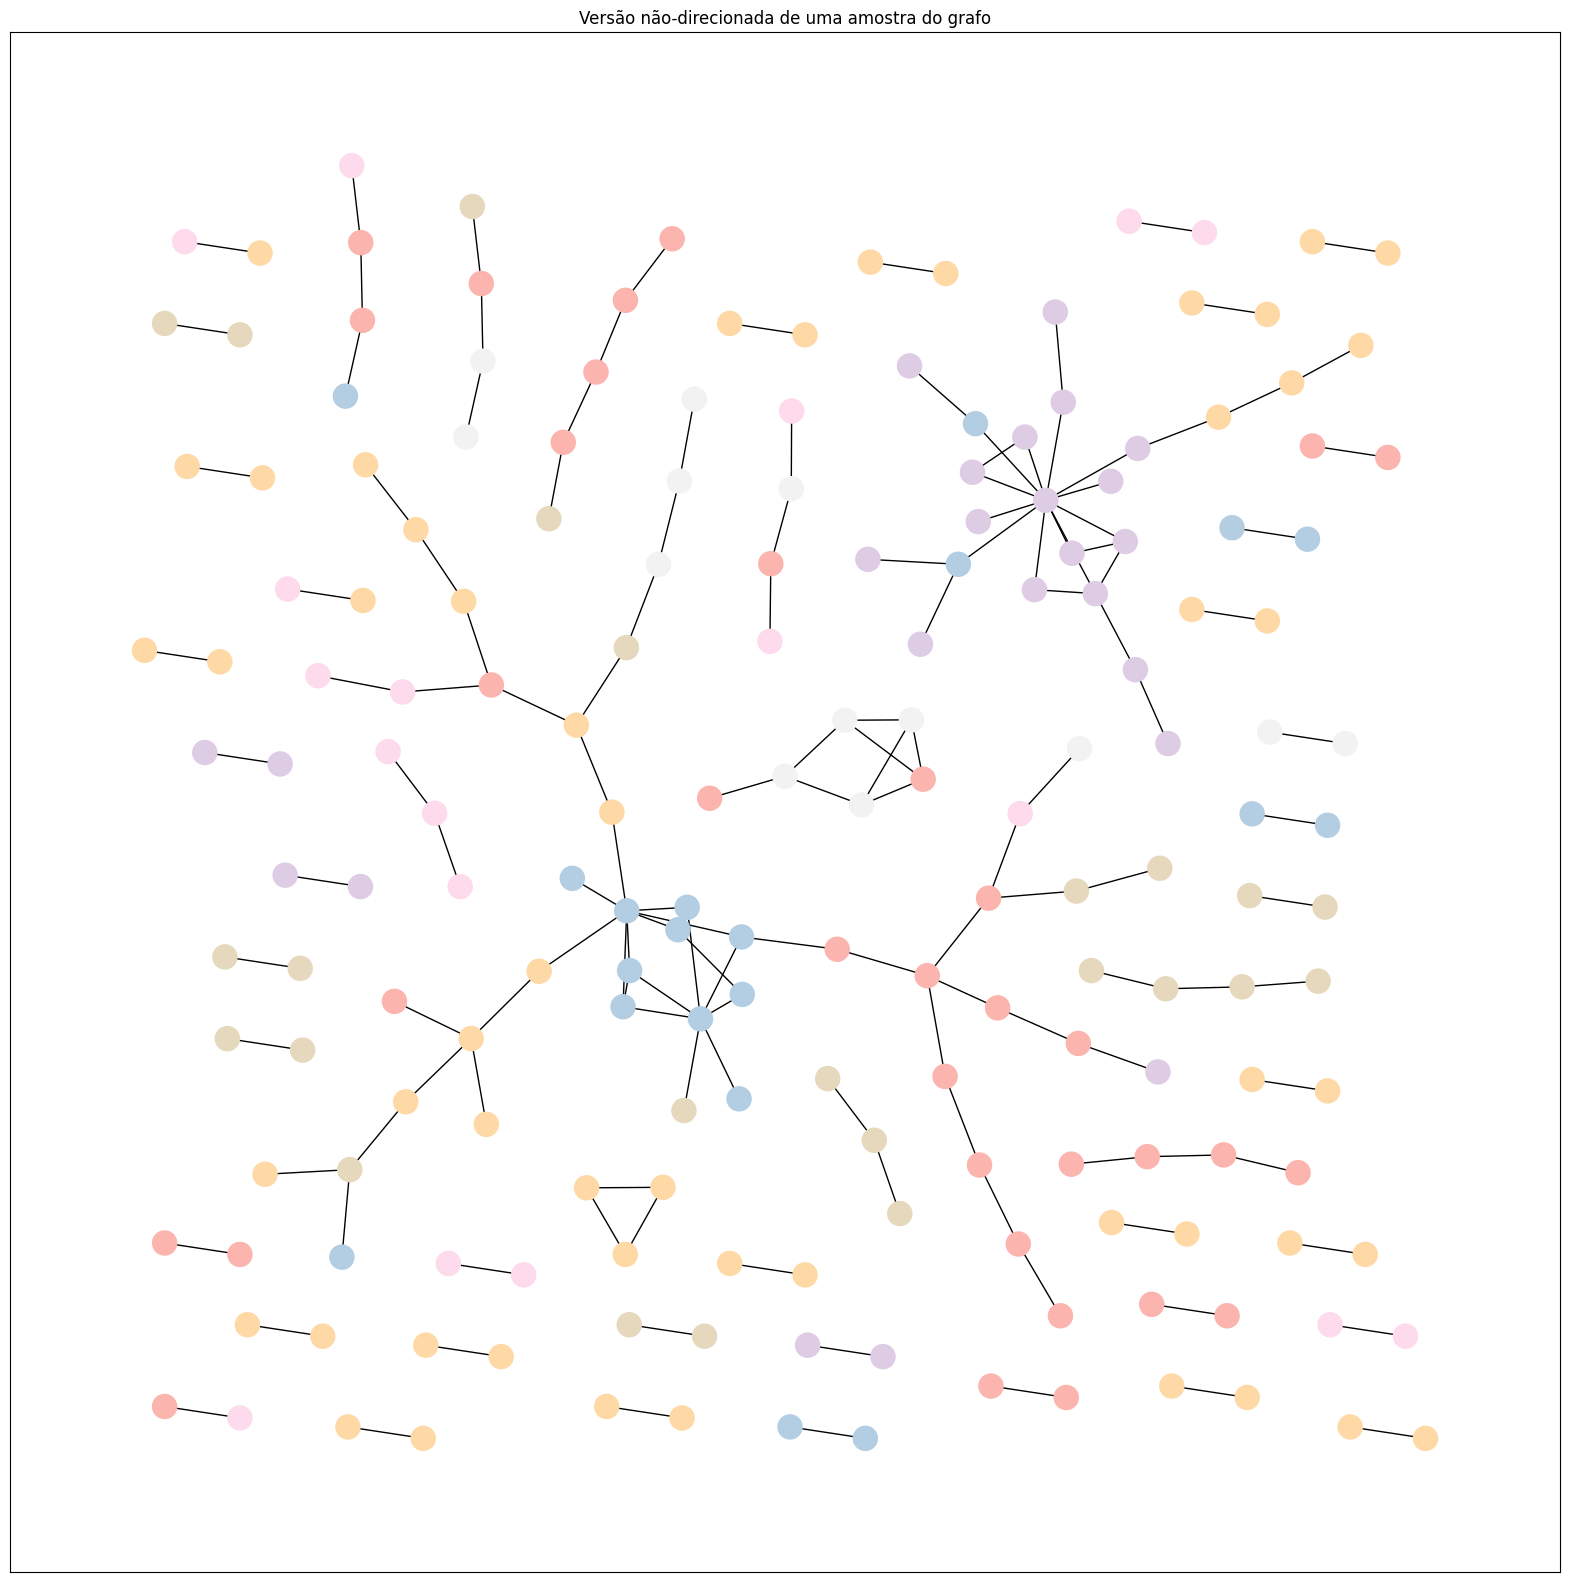

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import random

# sample a subgraph with 100 edges (random)
k = 100
g = to_networkx(data, node_attrs=["y"], to_undirected=True)
sampled_edges = random.sample(sorted(g.edges), k)
sampled_nodes = list(set(list(sum(sampled_edges, ()))))
sampled_graph = g.subgraph(sampled_nodes)

# draw graph with colors representing document classes
plt.figure(figsize=(20, 20))
plt.title("Versão não-direcionada de uma amostra do grafo")
labels = nx.get_node_attributes(sampled_graph, "y", default=-1)
pos = nx.nx_agraph.graphviz_layout(sampled_graph, prog="neato")
nx.draw_networkx_nodes(sampled_graph, pos, node_color=list(labels.values()), cmap=plt.cm.Pastel1)
nx.draw_networkx_edges(sampled_graph, pos)

plt.show()

## Modelo Node2Vec: obtendo representações vetoriais para os vértices (Shallow embedding)
- Neste caso, se trata de um processo totalmente não-supervisionado. Isto é, ignoramos as features ```data.x``` por enquanto.
- A ideia é que as representações vetoriais sejam baseadas apenas na estrutura do grafo: vértices de classes iguais teriam representações vetoriais similares (próximas)
- Processo geral: otimizar uma função para cada vértice a partir de caminhamentos aleatórios (random walks) a partir de um vértice

![Node2VecGraph](node2vec.png "Title")
fonte: [Grover et al. 2016](https://arxiv.org/pdf/1607.00653)

### Configurando um modelo Node2Vec

In [44]:
import torch
from torch_geometric.nn.models import Node2Vec

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,        # quantas dimensões terão as representações vetoriais
    walk_length=20,           # tamanho dos caminhamentos em qtde de vértices
    context_size=10,          # janela utilizada para extrair subcaminhamentos de um caminhamento
    walks_per_node=10,        # qtde de caminhamentos a serem extraídos por vértice
    num_negative_samples=1,   # quantos caminhamentos negativos por caminhamento gerado
    p=1.0,                    # controla a chance de revisitar um vértice do caminhamento
    q=1.0,                    # controla a alternância entre BFS e DFS nos caminhamentos
).to(device)

### Configurando o otimizador que irá guiar o treino do modelo Node2Vec

In [45]:
loader = model.loader(batch_size=128, shuffle=True) # modelo gera random walks para grupos de vértice (128)
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01) # otimizador incorpora os parâmetros do modelo para otimizá-lo

### Definindo o procedimento de uma rodada de treino

In [46]:
def train():
    model.train() # indica que o modelo vai ser treinado (ajustado)
    total_loss = 0
    for pos_rw, neg_rw in loader: # para cada grupo de vértices e seus random walks
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device)) # calcula a perda do modelo
        loss.backward() # a perda do modelo permite reajustar os parâmetros (utilizando os gradientes)
        optimizer.step() # indica uma rodada de forward/backward
        total_loss += loss.item() # acumula as perdas em todos os grupos
    return total_loss / len(loader) # perda média

### Definindo o procedimento de teste para o modelo corrente

In [47]:
@torch.no_grad()
def test():
    model.eval() # indica que o modelo vai ser avaliado
    z = model() # predições das classes que obtidas pelo modelo

    # model.test é feito através de uma regressão logística multi classe usando os embeddings
    
    # validação
    acc_val = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.val_mask],
        test_y=data.y[data.val_mask],
        max_iter=150,
    )

    # teste
    acc_test = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )

    return acc_val, acc_test

### Dispara as rodadas de treino/validação/teste para cada epoch

In [48]:
num_epochs = 100
for epoch in range(1, num_epochs+1):
    loss = train()
    acc_val, acc_test = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AccVal: {acc_val:.4f}, AccTest: {acc_test:.4f}')

Epoch: 001, Loss: 8.1234, AccVal: 0.1680, AccTest: 0.1750
Epoch: 002, Loss: 6.0952, AccVal: 0.1820, AccTest: 0.1910
Epoch: 003, Loss: 4.9755, AccVal: 0.2000, AccTest: 0.2320
Epoch: 004, Loss: 4.1548, AccVal: 0.2260, AccTest: 0.2620
Epoch: 005, Loss: 3.4934, AccVal: 0.2580, AccTest: 0.3050
Epoch: 006, Loss: 2.9768, AccVal: 0.2960, AccTest: 0.3330
Epoch: 007, Loss: 2.5561, AccVal: 0.3320, AccTest: 0.3650
Epoch: 008, Loss: 2.2280, AccVal: 0.3620, AccTest: 0.4050
Epoch: 009, Loss: 1.9566, AccVal: 0.4080, AccTest: 0.4130
Epoch: 010, Loss: 1.7412, AccVal: 0.4460, AccTest: 0.4460
Epoch: 011, Loss: 1.5702, AccVal: 0.4740, AccTest: 0.4680
Epoch: 012, Loss: 1.4290, AccVal: 0.4940, AccTest: 0.4870
Epoch: 013, Loss: 1.3199, AccVal: 0.5060, AccTest: 0.5080
Epoch: 014, Loss: 1.2322, AccVal: 0.5260, AccTest: 0.5330
Epoch: 015, Loss: 1.1639, AccVal: 0.5460, AccTest: 0.5580
Epoch: 016, Loss: 1.1063, AccVal: 0.5580, AccTest: 0.5830
Epoch: 017, Loss: 1.0590, AccVal: 0.5760, AccTest: 0.5910
Epoch: 018, Lo

### Visualiza os embeddings produzidos em relação às suas respectivas classes
- Veja que estamos utilizando TSNE para obter uma representação aproximada 2d dos embeddings


Embeddings para cada vértice:
torch.Size([2708, 128])
Parameter containing:
tensor([[-0.0185, -0.0957,  0.0654,  ...,  0.0774, -0.0540, -0.0549],
        [-0.3396,  0.2103,  0.4079,  ..., -0.0464,  0.1641,  0.0223],
        [-0.2835,  0.1439,  0.7047,  ..., -0.1190,  0.2044, -0.0190],
        ...,
        [ 0.7850, -0.3183,  0.1565,  ...,  0.4227, -0.0575,  0.0799],
        [-0.2008,  0.1090,  0.2227,  ...,  0.2577,  0.0152, -0.0941],
        [-0.1023, -0.0354,  0.2145,  ...,  0.2063,  0.0350, -0.0949]],
       device='cuda:0', requires_grad=True)



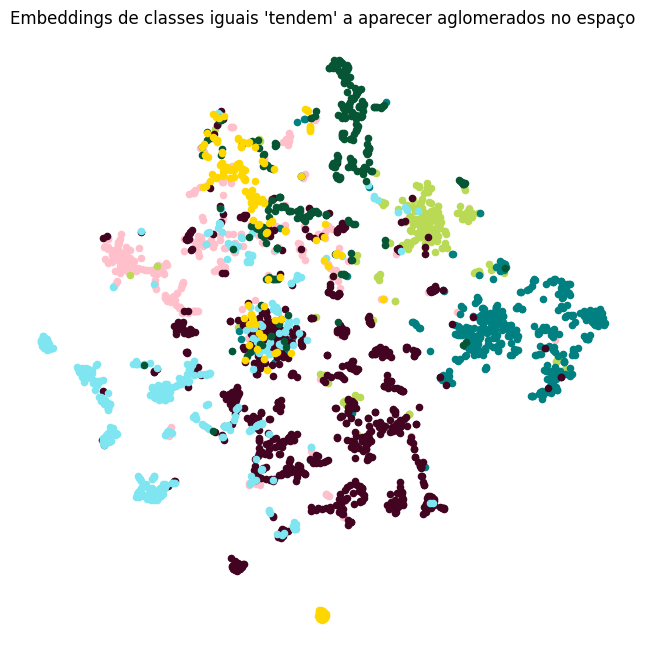

In [49]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = PCA(n_components=50).fit_transform(z)
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.title("Embeddings de classes iguais 'tendem' a aparecer aglomerados no espaço")
    plt.axis("off")
    plt.show()


# tensor com os embeddings
z = model()
print(f"\nEmbeddings para cada vértice:\n{z.shape}\n{z}\n")

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)